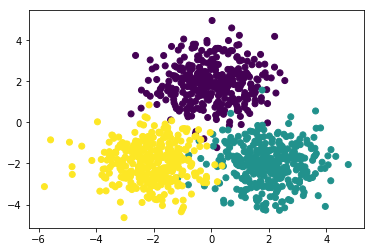

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun April 5th

@author: Joshuah Touyz
@class: Anly-601
@title: HW3 Part 3
@lecture: L11 - Intro to deep learning
"""
# ---- Programming backprop from scratch -----
##########################
#   Importing libraries  #
##########################
import numpy as np
import pandas as pd
from matplotlib import pyplot as py
%matplotlib inline 
import time

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Generate some training    #
#      data from a GMM        #
###############################
def gen_gmm_data(n = 999, plot=False):
    # Fixing seed for repeatability
    np.random.seed(123)
    
    # Parameters of a normal distribuion
    mean_1 = [0, 2] ; mean_2 = [2, -2] ; mean_3 = [-2, -2]
    mean = [mean_1, mean_2, mean_3] ; cov = [[1, 0], [0, 1]]  
    
    # Setting up the class probabilities
    n_samples = n
    pr_class_1 = pr_class_2 = pr_class_3 = 1/3.0
    n_class = (n_samples * np.array([pr_class_1,pr_class_2, pr_class_3])).astype(int)
  
    # Generate sample data
    for i in range(3):
        x1,x2 = np.random.multivariate_normal(mean[i], cov, n_class[i]).T
        if (i==0):
            xs = np.array([x1,x2])
            cl = np.array([n_class[i]*[i]])
        else: 
            xs_new = np.array([x1,x2])
            cl_new = np.array([n_class[i]*[i]])
            xs = np.concatenate((xs, xs_new), axis = 1)
            cl = np.concatenate((cl, cl_new), axis = 1)
    
    # Plot?
    if plot:
        py.scatter(xs[:1,:],xs[1:,:], c = cl)

    # One hot encoding classes
    y = pd.Series(cl[0].tolist())
    y = pd.get_dummies(y).as_matrix() 

    # Normalizing data (prevents overflow errors)     
    mu = xs.mean(axis = 1)
    std = xs.std(axis = 1)
    xs = (xs.T - mu) / std
    
    return xs, y, cl
             
xs,y,cl = gen_gmm_data(plot = True)

In [18]:
#%%%%%%%%%%%%%%%%%%%%%%%
#    Hidden Units     #
#######################
ReLU = np.vectorize(lambda z: np.fmax(0,z))
sigmoid = lambda z: 1 / (1 + np.exp(-z))
softmax = lambda z: np.exp(z)/(np.sum(np.exp(z),axis=1))[:,np.newaxis]

# %%%%%%%%%%%%%%%%%%%%%
#  Utility Functions  #
# #####################
def predict(Y_hat):
    return np.argmax(Y_hat, axis=1)


def error_rate(Y_hat, cl):
    prediction = predict(Y_hat)
    return np.mean(prediction != cl)


def cost(Y_hat, Y):
    tot = Y * np.log(Y_hat)
    return -tot.sum()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   1- Hidden Layer ReLU Network   #
####################################
def forward(X,parameters, drop_out = 1):
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    
    # Forward pass
    a1 = X.dot(W) + b1
    H = ReLU(a1) * drop_out
    #H = sigmoid(a1) * drop_out
    a2 = H.dot(V) + b2
    Y_hat = softmax(a2)
    return H,Y_hat

#%%%%%%%%%%%%%%%
#   Gradient   #
################

def grad(X,H,Y,Y_hat,parameters):  
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    # Gradients - ReLU
    dV = H.T.dot(Y_hat - Y)
    db2 = (Y_hat - Y).sum(axis=0)
    dW = X.T.dot(((Y_hat - Y).dot(V.T) * (H > 0))) 
    db1 = ((Y_hat - Y).dot(V.T) * (H > 0)).sum(axis=0)
    
    # Gradients - sigmoid
    # dW = X.T.dot((Y_hat-Y).dot(V) * (H * (1 - H)))
    # db1 = (Y_hat-Y).dot(V) * (H * (1 - H)).sum(axis=0)
    
    
    #return {'dV':dV,'db2':db2,'dW':dW,'db1':db1}
    return dW,db1,dV,db2

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Parameter Update: Momentum + Regularization   #
###################################################
def parameter_update(parameters,  grads, 
                     momentum_params = [0,0,0,0], 
                     lr = 1, reg = 0, alpha = 0):
    # Unpacking parameters            
    W,b1,V,b2 = parameters
    dW,db1,dV,db2 = grads
    vW,vb1,vV,vb2 = momentum_params
    
    # Momentum update
    vW  = alpha * vW -  lr * (dW + reg*W)
    vb1 = alpha * vb1 - lr * (db1 + reg*b1)
    vV  = alpha * vV -  lr * (dV + reg*V)
    vb2 = alpha * vb2 - lr * (db2 + reg*b2)
    momentum_params = [vW,vb1,vV,vb2] 
    
    # Parameter updates
    W  = W  + vW
    b1 = b1 + vb1
    V  = V  + vV
    b2 = b2 + vb2
    parameters =[W,b1,V,b2]

             
    return parameters, momentum_params

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#  Generate data for network    #
#################################
X, Y, cl = gen_gmm_data()

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#      Building the model     #
###############################
def run_model(X, Y, cl,
              nodes_in_hidden_layer = 3,
              num_dim = 2,     # <- number of dimensions here it is 2: x1,x2
              num_classes = 3, # <- number of classes in the problem
              iterations = 1000,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False):    

    
    ###################################
    #   Initial values for network    #
    ###################################
    # Intialize weights
    np.random.seed(123)
    W = np.random.randn(num_dim * nodes_in_hidden_layer).reshape(num_dim,nodes_in_hidden_layer)
    b1 = 0
    V = np.random.randn(num_classes * nodes_in_hidden_layer).reshape(nodes_in_hidden_layer,num_classes)
    b2 = 0
    parameters = [W,b1,V,b2]
    
    
    # Hyperparameters 
    lr = 0.0001 # learning rate
    reg = 0.01 * regularization_include
    
    # Momentum parameters
    alpha = 0.9 * momentum_include
    vV = 0
    vb2 = 0
    vW = 0
    vb1 = 0
    momentum_params = [vW,vb1,vV,vb2]    
    
    # Place holder for losses
    losses = []
    errors = []    
   
    ###################
    #   Run the model #
    ###################
    for i in range(0,iterations):
        # -- Drop Out Mask --
        # When !=1 then ddrop rate is 12.5%  (~0.5/4 = 12.5%)
        # Short cut to include drop_out 
        drop_out =  (1 - drop_out_include) + drop_out_include * np.round(1-np.random.rand(nodes_in_hidden_layer)/4) 
        
        # -- Forward propoagation --
        H,Y_hat = forward(X,parameters,drop_out)
        
        # -- Backward propagation --
        # Gradient calculation
        grads_in = grad(X,H,Y,Y_hat,parameters)
        # Parameter update
        new_params, new_mom_param = parameter_update(parameters, grads_in, 
                             momentum_params, alpha = alpha, 
                             lr = lr, reg = reg)
        
        # -- Updating values --
        H,Y_hat = forward(X,new_params, drop_out)
        parameters = new_params
        momentum_params = new_mom_param
        # Prediction and Error rate            
        errs_i = error_rate(Y_hat, cl) ; errors.append(errs_i)
        loss_i = cost(Y_hat, Y); losses.append(loss_i)
        if ((i % 25) == 0):    
            print(
            '''
            ---- Iteration {i} ----
            Error rate : {er}
            Loss: {loss}
            '''.format(i= i, er = errs_i, loss = loss_i))
    return {"errors":errs_i, "loss_i":loss_i, "parameters":parameters, "losses": losses, "errors": errors}

In [19]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Running Different Models  #
###############################
print("------Begin with vanilla_sgd------")
start_time = time.clock()
vanilla_sgd = run_model(X,Y,cl, iterations = 100, nodes_in_hidden_layer=5,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False)
print("------Time spent for vanilla_sgd:", time.clock() - start_time)

print("------Begin with sgd_w_reg------")
start_time = time.clock()
sgd_w_reg = run_model(X,Y,cl, iterations=100, nodes_in_hidden_layer=5,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)
print("------Time spent for sgd_w_reg:", time.clock() - start_time)

print("------Begin with sgd_w_reg_momentum------")
start_time = time.clock()
sgd_w_reg_momentum = run_model(X,Y,cl, iterations=100, nodes_in_hidden_layer=5,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)
print("------Time spent for sgd_w_reg_momentum:", time.clock() - start_time)

print("------Begin with sgd_w_reg_momentum_drop_out------")
start_time = time.clock()
sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations=100, nodes_in_hidden_layer=5,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True) 
print("------Time spent for sgd_w_reg_momentum_drop_out:", time.clock() - start_time)

------Begin with vanilla_sgd------

            ---- Iteration 0 ----
            Error rate : 0.5665665665665666
            Loss: 2614.817307396562
            

            ---- Iteration 25 ----
            Error rate : 0.19519519519519518
            Loss: 611.3706509095945
            

            ---- Iteration 50 ----
            Error rate : 0.06806806806806807
            Loss: 383.2276735915491
            

            ---- Iteration 75 ----
            Error rate : 0.042042042042042045
            Loss: 251.5054950877491
            
------Time spent for vanilla_sgd: 2.096684500000265
------Begin with sgd_w_reg------

            ---- Iteration 0 ----
            Error rate : 0.5665665665665666
            Loss: 2614.812898743622
            

            ---- Iteration 25 ----
            Error rate : 0.19519519519519518
            Loss: 611.3780321566293
            

            ---- Iteration 50 ----
            Error rate : 0.06806806806806807
            Loss: 383.

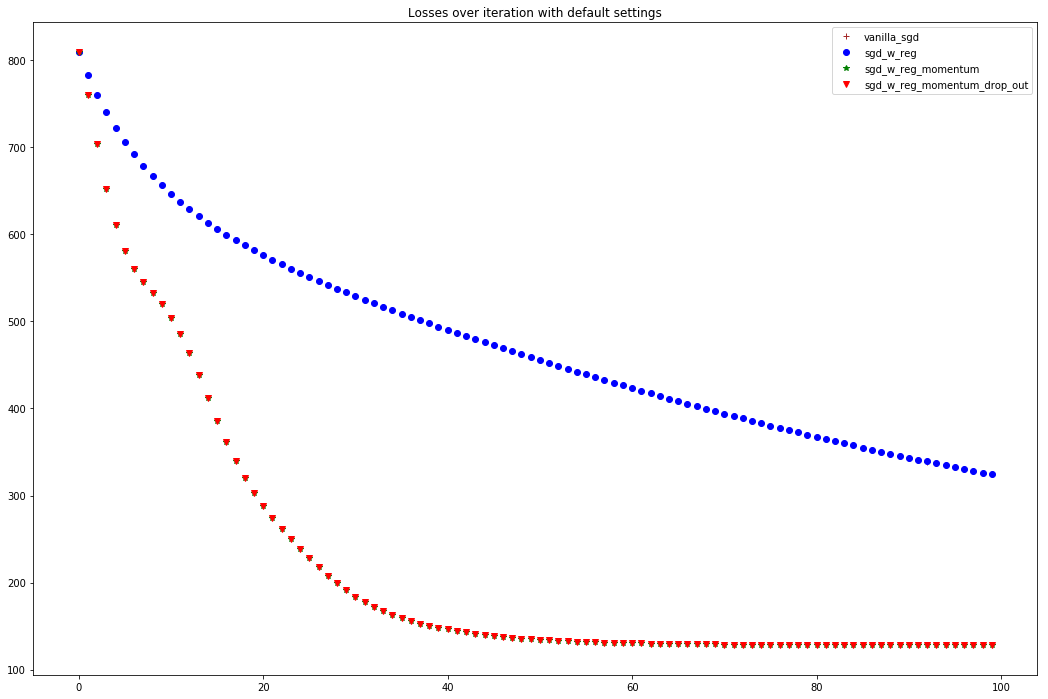

In [10]:
py.figure(figsize=(18,12))
py.plot(range(100), vanilla_sgd['losses'], '+', color='brown', label='vanilla_sgd')
py.plot(range(100), sgd_w_reg['losses'], 'o', color='blue', label='sgd_w_reg')
py.plot(range(100), sgd_w_reg_momentum['losses'], '*', color='green', label='sgd_w_reg_momentum')
py.plot(range(100), sgd_w_reg_momentum_drop_out['losses'], 'v', color='red', label='sgd_w_reg_momentum_drop_out')
py.legend()
py.title('Losses over iteration with default settings')
py.savefig("./sigmoid_hidden_3.jpg")

In [20]:
print("Loss vanilla_sgd:", vanilla_sgd['losses'][-1])
print("Loss sgd_w_reg:", sgd_w_reg['losses'][-1])
print("Loss sgd_w_reg_momentum:", sgd_w_reg_momentum['losses'][-1])
print("Loss sgd_w_reg_momentum_drop_out:", sgd_w_reg_momentum_drop_out['losses'][-1])

Loss vanilla_sgd: 182.36628686
Loss sgd_w_reg: 182.380344522
Loss sgd_w_reg_momentum: 79.4183783253
Loss sgd_w_reg_momentum_drop_out: 79.4183783253


In [20]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#       Execution time.      #
###############################
start_time = time.clock()
run_model(X,Y,cl, iterations = 100,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False)
print(time.clock() - start_time, "seconds")


            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5034085448333
            

            ---- Iteration 25 ----
            Error rate : 0.04504504504504504
            Loss: 230.39605917572294
            

            ---- Iteration 50 ----
            Error rate : 0.03303303303303303
            Loss: 150.17197232981292
            

            ---- Iteration 75 ----
            Error rate : 0.03003003003003003
            Loss: 120.61145170075918
            
1.5751335999998446 seconds
